In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50 ,DenseNet121, EfficientNetB7,VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import ModelCheckpoint , ReduceLROnPlateau, EarlyStopping
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
# Load the dataset
df = pd.read_csv('sufffle_image.csv')
df["category"] = df["category"].replace({0: 'Normal', 1: 'COVID-19', 2: 'Viral Pneumonia'})

In [4]:
# Divide the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.20, random_state=42)
validate_df,test_df = train_test_split(val_df, test_size=0.50, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [5]:
# Set your IMAGE_SIZE and other parameters
IMAGE_SIZE = (180,180)
batch_size = 16

In [6]:
#Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     rescale=1./255,
#     shear_range=0.1,
#     # zoom_range=0.2,
#     horizontal_flip=True,
    
#     brightness_range=[0.5, 1.5],
#     channel_shift_range=0.2,
#     vertical_flip=True,
#     preprocessing_function=lambda x: x + 0.01 * np.random.randn(*x.shape),
#     # random_rotation=30,
#     height_shift_range=0.1,
#     width_shift_range=0.1,
#     zoom_range=[0.8, 1.2],
#     # Exclude unsupported parameter
# )

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
      batch_size=batch_size
)
   

Found 27120 validated image filenames belonging to 3 classes.
Found 3390 validated image filenames belonging to 3 classes.


In [7]:
# # Freeze layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

In [8]:
def sequential1(model,units):
   
    model.add(Conv2D(units,(3,3),padding='same',activation='relu'))
    model.add(Conv2D(units,(3,3),padding = 'same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides= 2))
    return model

In [9]:
def sequential2(model,size):
    
    model.add(Dense(size,activation='relu'))
    model.add(Dense(size,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    return model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

# Conv2d_2 (conv2d) (180, 180, 16) 448
model.add(Conv2D(16, (3, 3), input_shape=(180, 180, 3), padding='same', activation='relu'))
# Conv2d_3 (conv2d) (180, 180, 16) 2320
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# Max_pooling2d_1 (90, 90, 16) 0
model.add(MaxPooling2D(pool_size=(2, 2), strides= 2))
sequential1(model,32)
sequential1(model,64)
sequential1(model,128)
# Dropout (dropout) (11, 11, 128) 0
model.add(Dropout(0.5))

sequential1(model,256)

# Dropout_1 (dropout) (5, 5, 256) 0
model.add(Dropout(0.5))

# Flatten (flatten) (6400) 0
model.add(Flatten())

# Sequential_4 (sequential) (512) 3279360
sequential2(model,512)
sequential2(model,128)
sequential2(model,64)


# Dense_7 (dense) (512) 33280
model.add(Dense(512, activation='relu'))
# Dense_8 (dense) (3) 1539
model.add(Dense(3, activation='softmax'))

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 32)       128       
 ormalization)                                          

In [11]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, name="custom_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

In [12]:
custom_loss = CustomLoss()

In [13]:
# Compile the model
# model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=0.001), loss=custom_loss, metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 32)       128       
 ormalization)                                          

 max_pooling2d_3 (MaxPooling  (None, 11, 11, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 11, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 256)       295168    
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 256)       590080    
                                                                 
 batch_normalization_3 (Batc  (None, 11, 11, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 256)        0         
 2D)                                                             
                                                                 
 dropout_1

c:\Users\Iftek\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.000001)
earlystop = EarlyStopping(
    monitor='val_loss',  # You can change this to another metric like 'val_accuracy'
    patience=10,  # Wait for 10 epochs to see if overfitting is resolved
    restore_best_weights=True,
    verbose=1
)
callbacks = [earlystop, learning_rate_reduction]
# callbacks = [earlystop, learning_rate_reduction]
# callbacks = [learning_rate_reduction]

In [15]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [16]:
# Fit the model
epochs = 100

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks
)

C:\Users\Iftek\AppData\Local\Temp\ipykernel_13488\1210727046.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
1695/1695 [==============================] - 346s 199ms/step - loss: 0.1442 - accuracy: 0.6784 - val_loss: 0.1028 - val_accuracy: 0.7491 - lr: 0.0010
Epoch 2/100
1695/1695 [==============================] - 229s 135ms/step - loss: 0.1019 - accuracy: 0.7854 - val_loss: 0.0770 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 3/100
1695/1695 [==============================] - 233s 137ms/step - loss: 0.0877 - accuracy: 0.8208 - val_loss: 0.2341 - val_accuracy: 0.5527 - lr: 0.0010
Epoch 4/100
1695/1695 [==============================] - 234s 138ms/step - loss: 0.0791 - accuracy: 0.8406 - val_loss: 0.0801 - val_accuracy: 0.8320 - lr: 0.0010
Epoch 5/100
1695/1695 [==============================] - 233s 137ms/step - loss: 0.0716 - accuracy: 0.8582 - val_loss: 0.1937 - val_accuracy: 0.6579 - lr: 0.0010
Epoch 6/100
1695/1695 [==============================] - 234s 138ms/step - loss: 0.0619 - accuracy: 0.8776 - val_loss: 0.0635 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 7/100
1695/1695 [=====

In [17]:
model.save('cnn3281135.h5')


In [21]:
actual_epochs = len(history.history['loss'])

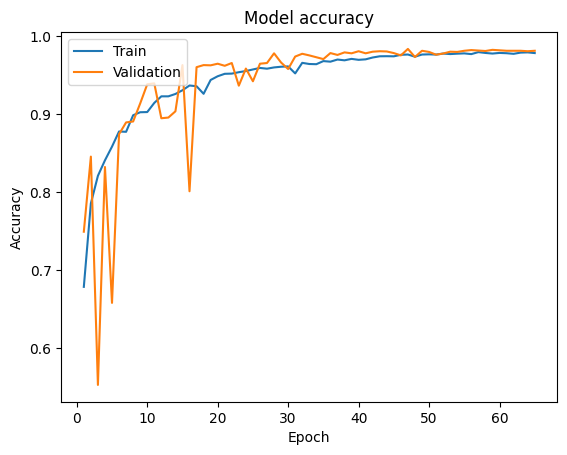

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
numEpochs = range(1,  actual_epochs + 1)
plt.plot(numEpochs,history.history['accuracy'])
plt.plot(numEpochs,history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

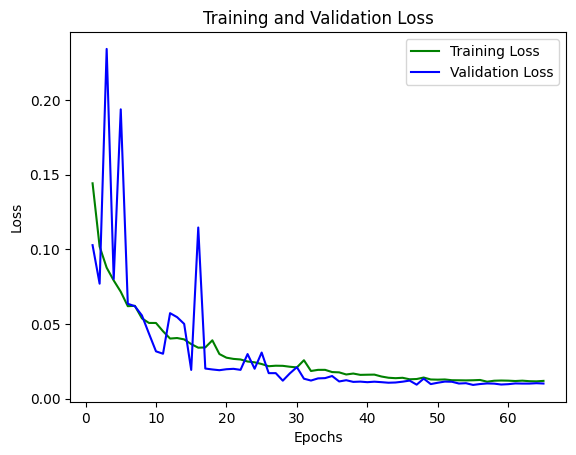

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  actual_epochs + 1)
plt.plot( numEpochs,loss, 'g', label='Training Loss')
plt.plot(numEpochs,val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

,filename,category
0,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal
1,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal
2,CLAHE\COVID-19_Radiography_Dataset\Viral Pneum...,Viral Pneumonia
3,Datasets\Pneumonia\Viral Pneumonia\images\pers...,Viral Pneumonia
4,CL+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19
...,...,...
3386,CL+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19
3387,HE\COVID-19_Radiography_Dataset\Viral Pneumoni...,Viral Pneumonia
3388,CLAHE\COVID-19_Radiography_Dataset\Viral Pneum...,Viral Pneumonia
3389,Datasets\COVID-19_Radiography_Dataset\COVID\im...,COVID-19


In [25]:
nb_samples = test_df.shape[0]

In [28]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(    
    test_df, 
    directory=None,
    x_col='filename',
    y_col='category',
    target_size = IMAGE_SIZE,
    
    class_mode='categorical',
    batch_size = batch_size,
    shuffle = False,
)

Found 3391 validated image filenames belonging to 3 classes.


In [29]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))
predict

C:\Users\Iftek\AppData\Local\Temp\ipykernel_13488\1469141313.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))


array([[4.8790153e-04, 9.9946874e-01, 4.3314009e-05],
       [2.6513559e-05, 9.9997222e-01, 1.2530684e-06],
       [1.0095834e-28, 8.4008062e-20, 1.0000000e+00],
       ...,
       [5.2155411e-28, 7.6871607e-21, 1.0000000e+00],
       [9.9874830e-01, 1.0947236e-03, 1.5687928e-04],
       [1.7699744e-03, 9.9385989e-01, 4.3701399e-03]], dtype=float32)

In [30]:
test_df['predict_category'] = np.argmax(predict, axis=-1)

In [31]:
test_df.head()

,filename,category,predict_category
0,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal,1
1,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal,1
2,CLAHE\COVID-19_Radiography_Dataset\Viral Pneum...,Viral Pneumonia,2
3,Datasets\Pneumonia\Viral Pneumonia\images\pers...,Viral Pneumonia,1
4,CL+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19,0


In [32]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['predict_category'] = test_df['predict_category'].replace(label_map)

In [33]:
test_df.head()

,filename,category,predict_category
0,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal,Normal
1,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal,Normal
2,CLAHE\COVID-19_Radiography_Dataset\Viral Pneum...,Viral Pneumonia,Viral Pneumonia
3,Datasets\Pneumonia\Viral Pneumonia\images\pers...,Viral Pneumonia,Normal
4,CL+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19,COVID-19


In [34]:
test_df['predict_category'] = test_df['predict_category'].replace({'Normal': 0, 'COVID-19': 1, 'Viral Pneumonia': 2})

<Axes: xlabel='category'>

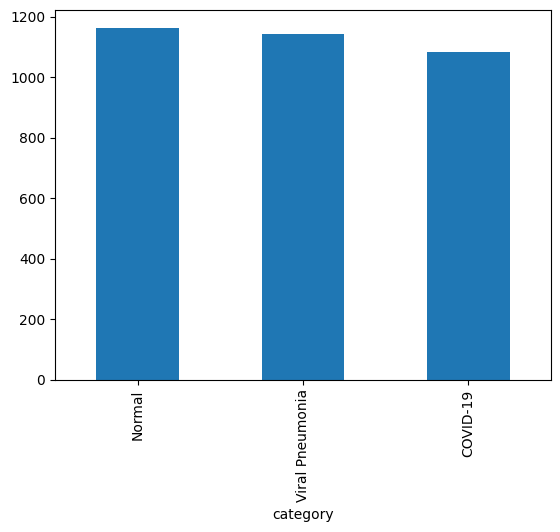

In [35]:
test_df['category'].value_counts().plot.bar()

In [38]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['predict_category']
    
    # img = load_img(filename, target_size=IMAGE_SIZE)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    # print(third_phrase)

    if 'Normal' in third_phrase:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'COVID' in third_phrase:
        
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'Viral Pneumonia' in third_phrase:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1
    

In [39]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

Model Accuracy: 98.11%
Correct Predictions: 3327 Total Predictions: 3391

Normal Predictions: 1151 Accuracy 98.88%
COVID-19 Predictions: 1058 Accuracy 97.69%
Viral Pneumonia Predictions: 1118 Accuracy 97.73%


In [44]:
actual = []
pred = []

for row in test_df.iterrows():
    
    filename = row[1][0]
    # print(filename)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    if 'Normal' in third_phrase: actual.append(0)
    if 'COVID' in third_phrase: actual.append(1)
    if 'Viral Pneumonia' in third_phrase: actual.append(2)
    # print(f'Actual :{row[1][1]}')   
    # print(f'prediction :{row[1][2]}')   
    pred.append(row[1][2])

C:\Users\Iftek\AppData\Local\Temp\ipykernel_13488\4069215994.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filename = row[1][0]
C:\Users\Iftek\AppData\Local\Temp\ipykernel_13488\4069215994.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred.append(row[1][2])


In [52]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [47]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1164
           1       0.99      0.98      0.99      1083
           2       0.99      0.98      0.98      1144

    accuracy                           0.98      3391
   macro avg       0.98      0.98      0.98      3391
weighted avg       0.98      0.98      0.98      3391



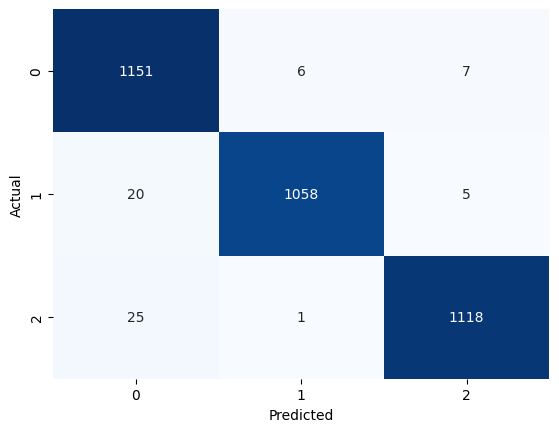

In [53]:
conf_matrix = confusion_matrix(actual, pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('cm.pdf')
plt.show()

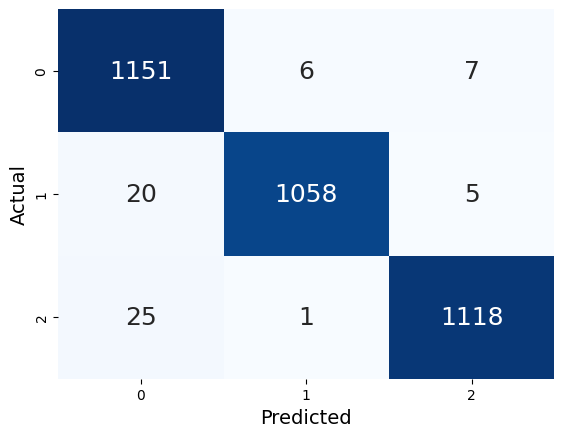

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = [[1151, 6, 7], [20, 1058, 5], [25, 1, 1118]]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 18})
plt.xlabel('Predicted', fontsize=14)  # Adjust the font size as needed
plt.ylabel('Actual', fontsize=14)  # Adjust the font size as needed
plt.savefig('cm_first.pdf')
plt.show()